## Gene LOF vs. selection frequency

TODO: describe in more detail

In [1]:
import sys
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg

%load_ext autoreload
%autoreload 2

In [2]:
gene = 'TP53'
mad_threshold = 100

In [3]:
# load LOF, etc
output_dir = cfg.data_dir / 'univariate_corrs'
output_file = output_dir / '{}_{}_corrs.tsv'.format(gene, mad_threshold)
rank_df = pd.read_csv(output_file, sep='\t')

print(rank_df.shape)
rank_df.head()

(100, 9)


,symbol,entrez_id,max - min,pancan,max_cancer_type,max_f_statistic,max_lof,abs_max_lof,symbol.1
0,KIF4A,24137,290.781887,1215.285958,BRCA,290.782276,-15.805231,15.805231,KIF4A
1,NCAPH,23397,302.217636,1170.548897,BRCA,302.217668,-7.904053,7.904053,NCAPH
2,PLK1,5347,351.053548,1124.041606,BRCA,351.056898,-28.995296,28.995296,PLK1
3,BUB1,699,277.920176,1061.147200,BRCA,277.925279,-7.312019,7.312019,BUB1
4,KIF23,9493,225.278353,923.233478,BRCA,225.280224,-19.845620,19.845620,KIF23


In [4]:
import glob

# process feature selection
# use models from mpmp paper here
models_dir = (
    Path('/home/jake/research/mpmp/') /
    '02_classify_mutations' / 
    'results' /
    'merged_expression' /
    'gene' / 
    gene
)
coefs_files = str(models_dir / 
    '{}_expression_signal_classify_s*_coefficients.tsv.gz'.format(gene)
)
coefs = []
for coefs_file in glob.glob(coefs_files):
    coefs.append(
        pd.read_csv(coefs_file, sep='\t')
    )
    
coefs_df = pd.concat(coefs)
print(coefs_df.shape)
coefs_df.head()

(64176, 8)


,feature,weight,abs,signal,seed,identifier,training_data,fold
0,4193,-0.78587,0.78587,signal,1,TP53,expression,0
1,581,-0.44985,0.44985,signal,1,TP53,expression,0
2,51065,-0.41703,0.41703,signal,1,TP53,expression,0
3,1643,-0.41383,0.41383,signal,1,TP53,expression,0
4,1026,-0.39162,0.39162,signal,1,TP53,expression,0


In [5]:
coefs_df['nz_weight'] = (coefs_df.weight != 0.)
coefs_df.head()

,feature,weight,abs,signal,seed,identifier,training_data,fold,nz_weight
0,4193,-0.78587,0.78587,signal,1,TP53,expression,0,True
1,581,-0.44985,0.44985,signal,1,TP53,expression,0,True
2,51065,-0.41703,0.41703,signal,1,TP53,expression,0,True
3,1643,-0.41383,0.41383,signal,1,TP53,expression,0,True
4,1026,-0.39162,0.39162,signal,1,TP53,expression,0,True


In [6]:
nz_models_df = (coefs_df
  .groupby('feature')
  .sum()
  .loc[:, ['nz_weight']]
)

nz_models_df.sort_values(by='nz_weight', ascending=False).head()

,nz_weight
feature,
log10_mut,8.0
4193,8.0
112,8.0
92579,8.0
50484,8.0


Text(0.5, 0, '')

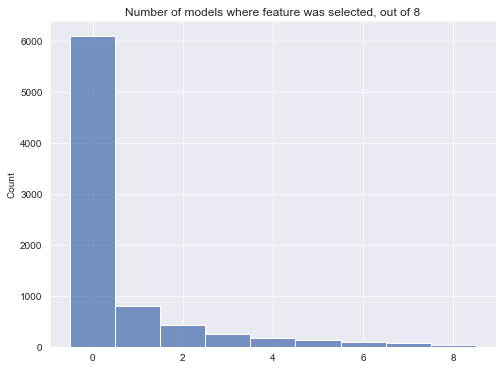

In [7]:
sns.set({'figure.figsize': (8, 6)})

sns.histplot(data=nz_models_df, x='nz_weight', discrete=True)
plt.title('Number of models where feature was selected, out of 8')
plt.xlabel('')

In [14]:
feats_in_top_n = (
    nz_models_df.index.isin(rank_df.entrez_id.astype(str))
)

nz_models_df.loc[feats_in_top_n, :].head()

,nz_weight
feature,
10053,1.0
10137,0.0
10236,0.0
10256,0.0
1040,2.0


Text(0.5, 0, '')

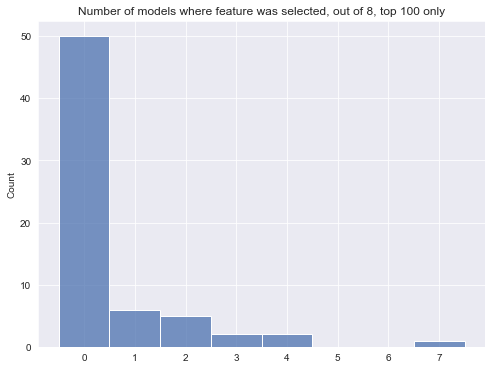

In [16]:
sns.set({'figure.figsize': (8, 6)})

sns.histplot(
    data=nz_models_df.loc[feats_in_top_n, :],
    x='nz_weight', discrete=True)
plt.title(
    'Number of models where feature was selected, out of 8, top {} only'.format(mad_threshold)
)
plt.xlabel('')